<a href="https://colab.research.google.com/github/alejandromaranon/FEM/blob/main/FEM_2D_placa_esf_plano_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejemplo: Placa - Esfuerzo Plano FEM 2D**

La placa cuadrada está sometida a dos cargas puntuales de $100 N$. Calcular los desplazamientos y esfuerzos en la placa utilizando dos elementos. El espesor de la placa es de $10 mm$. $E=270 GPa$, $\nu=0.33$


In [21]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/alejandromaranon/FEM/a2d148629000a40231008443bdbb1e193169ad60/Images/FEM_2D_placa_esf_plano_001.svg', width=500)

En este ejemplo se implementa el Método de Elementos Finitos (formulación local), para el cálculo de desplazamientos y esfuerzos en la placa.

In [22]:
import numpy as np
# import math as mt
import matplotlib.pyplot as plt
import matplotlib.tri as tri

**NOTA IMPORTANTE**:

En Python el primer indice (posición) de un arreglo (vector o matriz) es cero (0). A diferencia de Matlab, donde el primer indice es 1.


## Pre-procesamiento
Durante el preprocesamiento, se genera la malla para una geometría determinada y se especifican las propiedades de los materiales, las condiciones de frontera y las cargas prescritas.

In [23]:
# ----------
# Parámetros de control del problema
# ----------

# Geometría de la placa [SI]
L = 0.02          # Longitud [m]
h = 0.02          # Altura [m]
t = 0.01          # Ancho [m]

# Propiedades mecánicas del material
E = 270.0E9       # Módulo de Elasticidad [Pa]
nu= 0.33          # Relación de Poisson [-]

# Cargas sobre la viga
P = 100.0         # Carga puntual en el extremo (son dos cargas iguales)

# Discretización de elementos finitos
nel = 2               # Número de elementos
nod_el = 3            # Número de nodos por elemento.

nnodos = 4            # Número de nodos en el modelo
nod_dof = 2           # Número de grados de libertad (DOF) por nodo

el_dof = nod_el*nod_dof   # Número de DOF por elemento
mod_dof = nnodos*nod_dof  # Número de DOF en el modelo.


In [24]:
# ----------
# Coordenadas (localización) de cada uno de los nodos.
# Se almacena en el arreglo xy_coord, donde el numero de
# fila indica el número de nodo, la columna 0 (la primera) tiene la coordenada
# x del nodo y la columna 1 (la segunda) la coordenada y del nodo.
# ----------

xy_coord = np.zeros((nnodos, 2), dtype=float)

xy_coord[0] = [0.0, 0.0]
xy_coord[1] = [0.0, h]
xy_coord[2] = [L, 0.0]
xy_coord[3] = [L, h]

# print(xy_coord)

In [25]:
# ----------
# Arreglo de conectividad nodal de cada elemento
# (Topología de los elementos)
# ----------

# Se almacena en el arreglo C donde cada fila corresponde
# a un elemento. Las tres columnas son los nodos que pertenecen
# al elemento. Los nodos se listan en sentido contrario a las
# manecillas del reloj.

C = np.zeros((nel, 3), dtype=int)

C[0] = [0, 2, 3]
C[1] = [0, 3, 1]

# print(C)

In [26]:
# ----------
# Condiciones de frontera
# (Desplazamientos conocidos)
# ----------

# Se crean dos arreglos: cfdof que almacena el numero del D0F
# y el segundo cfval que almacena el valor de los desplazamientos
# conocidos en los DOF de cndof

cfdof = np.zeros((3, 1), dtype=int)    # Este arreglo almacenan los DOF
cfval = np.zeros((3, 1), dtype=float)  # Este arreglo almacenan los desplazamientos

cfdof[:, 0] = [0, 1, 2]
cfval[:, 0] = [0.0, 0.0, 0.0]

# print(cfdof, cfval)

In [27]:
# ----------
# Vector de fuerza (puntuales)
# ----------

# Se crean dos arreglos: fndof que almacenan los DOF
# y fnval que almacen el valor de la fuerzas en los DOF

# En este ejemplo existen dos cargas puntuales en el extremo.

fndof = np.zeros((2, 1), dtype=int)    # Este arreglo almacena los DOF
fnval = np.zeros((2, 1), dtype=float)  # Este arreglo almacena las fuerzas

fndof[:, 0] = [4, 6]
fnval[:, 0] = [P, P]

# print(fndof, fnval)

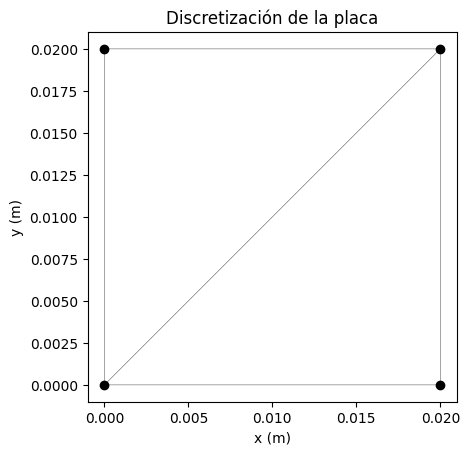

In [28]:
# ----------
# Visualización de la malla de elementos finitos
# ----------

# Create the Triangulation; no triangles so Delaunay triangulation created.
malla = tri.Triangulation(xy_coord[:, 0], xy_coord[:, 1], C)

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.triplot(malla, 'ko-', lw=0.25)
ax.set_title('Discretización de la placa')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

plt.show()

### Solución
Durante la solución, se calculan las matrices de elementos y se resuelven las ecuaciones.

In [29]:
# ----------
# Ensamblaje de la matriz de rigidez K y el vector
# de fuerza F (globales)
# ----------

# -----
# Inicializacion de matrices y vectores
# -----

K = np.zeros((mod_dof, mod_dof), dtype=float)     # Matriz de rigidez global
F = np.zeros((mod_dof, 1), dtype=float)           # Vector de fuerza global

# -----
# Definición de funciones auxiliares
# -----

# Area de un elemento dadas las cordenadas de los vertices
def area_elemento(coordenadas_vertices):

  x1 = coordenadas_vertices [0, 0]
  y1 = coordenadas_vertices [0, 1]
  x2 = coordenadas_vertices [1, 0]
  y2 = coordenadas_vertices [1, 1]
  x3 = coordenadas_vertices [2, 0]
  y3 = coordenadas_vertices [2, 1]

  area = abs((x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2)) / 2)

  return area

# Matriz [B] - Operador de gradiente semidiscretizado
def mat_B(coordenadas_vertices):

  x1 = coordenadas_vertices [0, 0]
  y1 = coordenadas_vertices [0, 1]
  x2 = coordenadas_vertices [1, 0]
  y2 = coordenadas_vertices [1, 1]
  x3 = coordenadas_vertices [2, 0]
  y3 = coordenadas_vertices [2, 1]

  # Calcula el area del elemento
  area = abs((x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2)) / 2)

  # Calcula las componentes de [B]
  b11 = (y2 - y3)/(2 * area)
  b13 = (y3 - y1)/(2 * area)
  b15 = (y1 - y2)/(2 * area)

  b22 = (x3 - x2)/(2 * area)
  b24 = (x1 - x3)/(2 * area)
  b26 = (x2 - x1)/(2 * area)

  B = np.array([[b11, 0.0, b13, 0.0, b15, 0.0],
                [0.0, b22, 0.0, b24, 0.0, b26],
                [b22, b11, b24, b13, b26, b15]], dtype=float)
  return B

# -----
# Calculo de matrices, vectores y ensamble
# -----

# --
# Matriz de coeficientes elásticos (esfuerzo plano)
# --

D = (E / (1 - nu**2)) * np.array([[1, nu, 0.0],
                                  [nu, 1, 0.0],
                                  [0.0, 0.0, (1-nu)/2]], dtype=float)

# --
# Calculo de la matriz de rigidez K (global)
# --

for num_ele in range(nel):

  # extrae los numeros globales de los nodos del elemento
  nodo1 = C[num_ele,0]
  nodo2 = C[num_ele,1]
  nodo3 = C[num_ele,2]

  # extrae las coordenadas de los nodos (x1, y1), (x2, y2), (x2, y3) y las
  # almacena en el arreglo coord_vert
  coord_vert = np.array([[xy_coord[nodo1, 0], xy_coord[nodo1, 1]],
                         [xy_coord[nodo2, 0], xy_coord[nodo2, 1]],
                         [xy_coord[nodo3, 0], xy_coord[nodo3, 1]]], dtype=float)

  # Calcula la matriz de rígidez del elemento
  B = mat_B(coord_vert)               # operador de gradiente semidiscretizado

  kk = area_elemento(coord_vert) * t * (np.transpose(B) @ D @ B) # kk=A*t*B'*D*B

  # print('kk_',num_ele,kk)

  # -
  # ensambla kk en K
  # -

  # Grados de libertad (dof) globales del elemento
  dof_glob = np.array([[2 * nodo1],
                       [2 * nodo1 + 1],
                       [2 * nodo2],
                       [2 * nodo2 + 1],
                       [2 * nodo3],
                       [2 * nodo3 + 1]], dtype=int)

  for i in range(el_dof):
    for j in range(el_dof):
      K[dof_glob[i] , dof_glob[j]] += kk[i,j]

# Construcción del vector de fuerza F (global):
# se incluyen en F las fuerzas aplicadas
# (almacendas en fndof y fnval)

for num_fn in range(fndof.shape[0]):
  F[fndof[num_fn]] += fnval[num_fn] # suma fnval[num_fn] al valor
                                    # almacenado en F[fndof[num_fn]]

# print(K, F)

In [30]:
# ----------
# Aplica las restricciones (desplazamientos conocidos)
# modificando K y F
# ----------

# Se utiliza una copia de K para incluir las condiciones de frontera cf
Kcf = np.copy(K)

for num_cf in range(cfdof.shape[0]):
  i = cfdof[num_cf]                  # este es el número de nodo.
  F[i] = cfval[num_cf]               # este es el desplazamiento conocido.

  for j in range(mod_dof):
    if i==j:
      Kcf[i,j] = 1.0
    else:
      Kcf[i,j] = 0.0

# print(Kcf,F)

In [31]:
# ----------
# Cálculo de desplazamientos nodales
# ----------

u = np.zeros((mod_dof, 1), dtype=float)   # vector con los grados de libertad
                                          # (desplazamientos) calculados

u = np.linalg.solve(Kcf,F)                # soluciona el sistema.

print(u)

[[-1.22564758e-23]
 [ 1.94147991e-23]
 [ 9.34521596e-24]
 [-2.44444444e-08]
 [ 7.40740741e-08]
 [-4.20009706e-23]
 [ 7.40740741e-08]
 [-2.44444444e-08]]


In [32]:
# ----------
# Calculo de reacciones nodales
# ----------

Rn = np.zeros((nnodos, 1), dtype=float)    # vector con las reacciones nodales.

Rn = K@u

print(Rn)

[[-1.00000000e+02]
 [ 2.84217094e-14]
 [-1.00000000e+02]
 [-1.42108547e-14]
 [ 1.00000000e+02]
 [-2.13162821e-14]
 [ 1.00000000e+02]
 [ 1.42108547e-14]]


In [33]:
# ----------
# Calculo de esfuerzos en los elementos
# ----------

esfuerzo = np.zeros((3, nel), dtype=float)    # vector los esfuerzos en cada elemento

esfuerzo_dof = np.zeros((nnodos, 3), dtype=float) # vector con esfuerzos en los nodos
                                                  # ver nota al final de esta celda.

for num_ele in range(nel):

  # extrae los numeros globales de los nodos del elemento
  nodo1 = C[num_ele,0]
  nodo2 = C[num_ele,1]
  nodo3 = C[num_ele,2]

  # extrae las coordenadas de los nodos (x1, y1), (x2, y2), (x2, y3) y las
  # almacena en el arreglo coord_vert
  coord_vert = np.array([[xy_coord[nodo1, 0], xy_coord[nodo1, 1]],
                         [xy_coord[nodo2, 0], xy_coord[nodo2, 1]],
                         [xy_coord[nodo3, 0], xy_coord[nodo3, 1]]], dtype=float)

  # Calcula la matriz de rígidez del elemento
  B = mat_B(coord_vert)               # operador de gradiente semidiscretizado

  # Extracción de los grados de libertad (desplazamientos) de los nodos del
  # elemento del vector solución u

  u_ele = np.array([u[2 * nodo1],
                    u[2 * nodo1 + 1],
                    u[2 * nodo2],
                    u[2 * nodo2 + 1],
                    u[2 * nodo3],
                    u[2 * nodo3 + 1]], dtype=float)

  # Se almacenan los esfuerzos sigma_xx, sigma_yy y tao_xy para cada elemento
  # por columna

  esfuerzo[:, num_ele] = np.squeeze(D @ B @ u_ele)

  # Para el postprocesamiento se almacenarán los esfuerzos en cada uno de los
  # nodos de la malla (dado que el esfuerzo es constante en el elemento, se
  # se asignará el mismo valor para los nodos que lo conforman.)

  esfuerzo_dof[nodo1, 0] = esfuerzo[0, num_ele]
  esfuerzo_dof[nodo2, 0] = esfuerzo[0, num_ele]
  esfuerzo_dof[nodo3, 0] = esfuerzo[0, num_ele]

  esfuerzo_dof[nodo1, 1] = esfuerzo[1, num_ele]
  esfuerzo_dof[nodo2, 1] = esfuerzo[1, num_ele]
  esfuerzo_dof[nodo3, 1] = esfuerzo[1, num_ele]

  esfuerzo_dof[nodo1, 2] = esfuerzo[2, num_ele]
  esfuerzo_dof[nodo2, 2] = esfuerzo[2, num_ele]
  esfuerzo_dof[nodo3, 2] = esfuerzo[2, num_ele]

print(esfuerzo)

[[ 1.00000000e+06  1.00000000e+06]
 [ 1.16415322e-10 -1.74622983e-10]
 [-5.82076609e-11 -8.73114914e-11]]


## Postprocesamiento

Esta etapa se utiliza para visualizar las soluciones y ver imágenes gráficas de los desplazamientos, esfuerzos, deformaciones, etc.

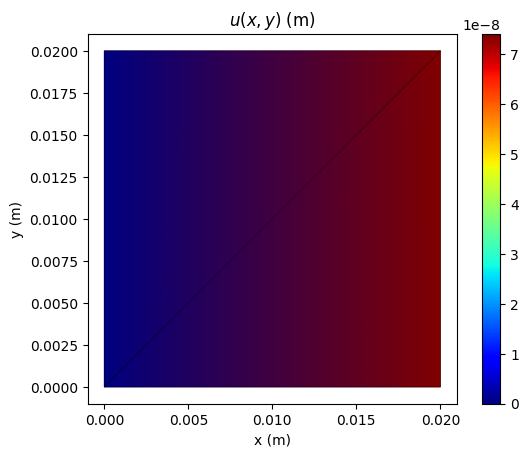

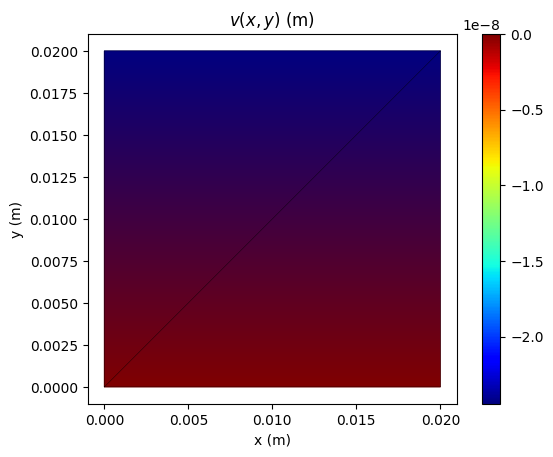

In [38]:
# ----
# Graficas de desplazamientos u(x,y) y v(x,y)
# ----

def graficar_desplazamiento(u, malla, tipo_desplazamiento='u'):
    """
    Función para graficar los desplazamientos horizontales y verticales
    a partir de un vector u.

    Parámetros:
    - u: el vector que contiene los valores de desplazamiento.
    - malla: los datos de triangulación para la gráfica.
    - tipo_desplazamiento:  str, tipo de desplazamiento a graficar
                            ('u' para desplazamiento horizontal,
                            'v' para desplazamiento vertical).
    """
    if tipo_desplazamiento == 'u':
        desplazamiento = u[::2]
        titulo = r'$u(x,y)$ (m)'
    elif tipo_desplazamiento == 'v':
        desplazamiento = u[1::2]
        titulo = r'$v(x,y)$ (m)'
    else:
        raise ValueError("tipo_desplazamiento debe ser 'u' o 'v'")

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    tpc = ax.tripcolor(malla, desplazamiento.flatten(), cmap='jet',shading='gouraud')
    ax.triplot(malla, 'k-', lw=0.25)
    fig.colorbar(tpc)
    ax.set_title(titulo)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

    plt.show()

graficar_desplazamiento(u, malla, tipo_desplazamiento='u')

graficar_desplazamiento(u, malla, tipo_desplazamiento='v')

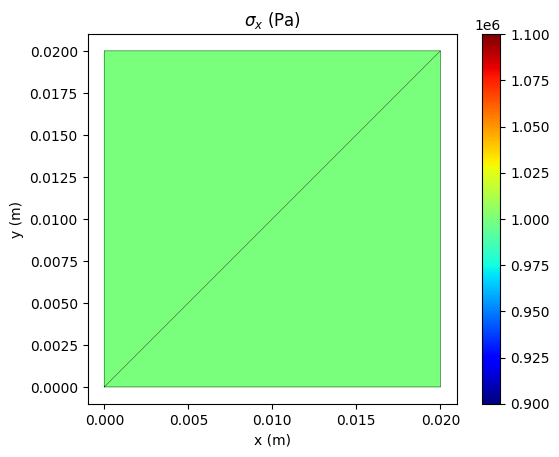

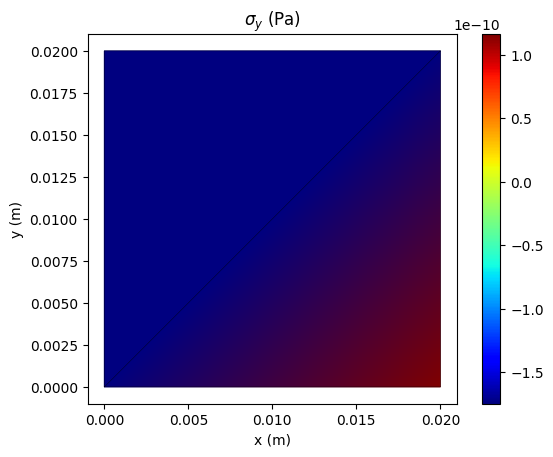

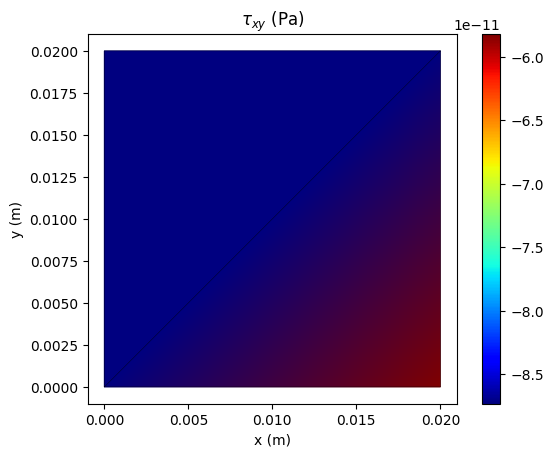

In [35]:
# ----
# Graficas de esfuerzos sigma_x(x,y), sigma_y(x,y) y tao_xy(x,y)
# ----

def graficar_esfuerzo(esfuerzo_dof, malla, tipo_esfuerzo='sigma_x'):
    """
    Función para graficar las componentes de esfuerzo a partir del
    vector "esfuerzo".

    Parámetros:
    - esfuerzo_dof: el vector que contiene las componentes de esfuerzo para
                    cada nodo.
    - malla: los datos de triangulación para la gráfica.
    - tipo_desplazamiento:  str, tipo de esfuerzo a graficar
                            ('sigma_x', 'sigma_y' y 'tao_xy').
    """
    if tipo_esfuerzo == 'sigma_x':
        esf = esfuerzo_dof[:, 0]
        titulo = r'$\sigma_x$ (Pa)'
    elif tipo_esfuerzo == 'sigma_y':
        esf = esfuerzo_dof[:, 1]
        titulo = r'$\sigma_y$ (Pa)'
    elif tipo_esfuerzo == 'tao_xy':
        esf = esfuerzo_dof[:, 2]
        titulo = r'$\tau_{xy}$ (Pa)'
    else:
        raise ValueError("tipo_desplazamiento debe ser 'sigma_x' o 'sigma_y' o 'tao_xy'")

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    tpc = ax.tripcolor(malla, esf.flatten(), cmap='jet', shading='gouraud')
    ax.triplot(malla, 'k-', lw=0.25)
    fig.colorbar(tpc)
    ax.set_title(titulo)
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

    plt.show()

graficar_esfuerzo(esfuerzo_dof, malla, tipo_esfuerzo='sigma_x')
graficar_esfuerzo(esfuerzo_dof, malla, tipo_esfuerzo='sigma_y')
graficar_esfuerzo(esfuerzo_dof, malla, tipo_esfuerzo='tao_xy')

In [36]:
# prompt: Stop execution

# import sys
# sys.exit()


EOF